# 9.66 Final Project: Guess the angle
## By Liane Xu and Grace Tian

Imagine you are rolling balls at an object at the center of the table in order to guess the rotation of the object (it is a square here). You place the ball on the table and give it a push (you know the starting position and initial velocity of the ball), but those are subject to your human error. 

In [1]:
using Gen, Plots, LinearAlgebra

### Utility Functions

In [1420]:
# Utility Functions
function getRotationMatrix(theta)
    return [cos(theta) -sin(theta); sin(theta) cos(theta)]
end

function makeBox(theta, scale)
    normals = [[0.0, -1.0], [1.0, 0.0], [0.0, 1.0], [-1.0, 0.0]]
    corners = [[1.0,1.0], [-1.0,1.0], [-1.0,-1.0], [1.0,-1.0]]
    for i in 1:4
        normals[i] = getRotationMatrix(theta) * normals[i]
        corners[i] = getRotationMatrix(theta) * corners[i] * scale
    end
    box = vcat(normals, corners)
    return box
end

function isInBox(box, point, scale)
    ABn = box[1] # normal defining AB (facing into the box)
    BCn = box[2]
    CDn = box[3]
    DAn = box[4]

    # dot product with normal (check which side of the hyperplane the point is on)
    mAB = Transpose(ABn) * point + scale
    mBC = Transpose(BCn) * point + scale
    mCD = Transpose(CDn) * point + scale
    mDA = Transpose(DAn) * point + scale

    # get around floating point error
    epsilon = 0.00001
    if mAB > -epsilon && mAB < epsilon
        mAB = 0.0
    end
    if mBC > -epsilon && mBC < epsilon
        mBC = 0.0
    end
    if mCD > -epsilon && mCD < epsilon
        mCD = 0.0
    end
    if mDA > -epsilon && mDA < epsilon
        mDA = 0.0
    end
    
    # dot product should be => 0 for all if the point is in the box
    if mAB < 0 
        return false
    end
     if mBC < 0
        return false
    end
    if mCD < 0
        return false
    end
    if mDA < 0
        return false
    end
    return true
end

# find the point of collision, normal at collision, and time of collision
# time of collision = Inf if there is no collision
function findIntersectionWithTrajectory(box, scale, O, V)
    # normals for each side of box
    ABn = box[1] # normal defining AB (facing inward)
    BCn = box[2]
    CDn = box[3]
    DAn = box[4]

    tAB = Inf
    tBC = Inf
    tBC = Inf
    tDA = Inf

    # time of collision with each side of box
    tAB = (-scale - (ABn[1]* O[1]) - (ABn[2]* O[2]))/(ABn[1]*V[1] + ABn[2]*V[2])
    tBC = (-scale - (BCn[1]* O[1]) - (BCn[2]* O[2]))/(BCn[1]*V[1] + BCn[2]*V[2])
    tCD = (-scale - (CDn[1]* O[1]) - (CDn[2]* O[2]))/(CDn[1]*V[1] + CDn[2]*V[2])
    tDA = (-scale - (DAn[1]* O[1]) - (DAn[2]* O[2]))/(DAn[1]*V[1] + DAn[2]*V[2])

    # filter out "collision" if it happens in negative time
    big = 10000000000
    if tAB == -Inf || tAB < 0 
        tAB = big
    end
    if tBC == -Inf || tBC < 0
        tBC = big
    end
    if tCD == -Inf || tCD < 0
        tCD = big
    end
    if tDA == -Inf || tDA < 0
        tDA = big
    end

    # find closest positive time of collision AKA the side of the box that the ball collides with
    current = big
    p = [big;big]
    n = [0.0;0.0]
    if tAB < current
        temp_p = O + V*tAB
        if isInBox(box, temp_p, scale)
            current = tAB
            p = O + V*tAB
            n = ABn
        end
    end
    if tBC < current
        temp_p = O + V*tBC
        if isInBox(box, temp_p, scale)
            current = tBC
            p = O + V*tBC
            n = BCn
        end
    end
    if tCD < current
        temp_p = O + V*tCD
        if isInBox(box, temp_p, scale)
            current = tCD
            p = O + V*tCD
            n = CDn
        end
    end
    if tDA < current
        temp_p = O + V*tDA
        if isInBox(box, temp_p, scale)
            current = tDA
            p = O + V*tDA
            n = DAn
        end
    end
    return (p, -n, current) #(point of intersection, -n so the n points outward, time of intersection)
end


# get the velocity after colliding with the object
function getOutVector(V_in, p, n)
    O_out = p 
    V_out = V_in - 2 * (Transpose(V_in) * n) * n # velocity after collision
    return O_out, V_out
end

# putting it all together
function getOutTrajectory(box, scale, O_in, V_in)
    p,n,t_out = findIntersectionWithTrajectory(box, scale, O_in, V_in) 
    O_out, V_out = getOutVector(V_in, p, n)
    return O_out, V_out, t_out
end

# for displaying
function grid(renderer::Function, traces)
    Plots.plot(map(renderer, traces)...)
end;

### Generative function

In [1435]:
# Generative function for noisy trajectory and noisy sample of ball
@gen function line_model(O_in, V_in, ts, jitter_x, jitter_y, box)
    jitterv = 0.15
    jitterpos = 0.05

    #Point of collision
    O_in_x = ({:O_in_x} ~ normal(O_in[1], jitterpos))
    O_in_y = ({:O_in_y} ~ normal(O_in[2], jitterpos))

    # Velocity before collision with box
    V_in_x = ({:V_in_x} ~ normal(V_in[1], jitterv)) 
    V_in_y = ({:V_in_y} ~ normal(V_in[2], jitterv))
    
    O_out, V_out, t_out = getOutTrajectory(box, 4, [O_in_x, O_in_y], [V_in_x, V_in_y])

    #Point of collision
    O_out_x = ({:O_out_x} ~ normal(O_out[1], jitterpos))
    O_out_y = ({:O_out_y} ~ normal(O_out[2], jitterpos))

    #Velocity after collision with box
    V_out_x = ({:V_out_x} ~ normal(V_out[1], jitterv))
    V_out_y = ({:V_out_y} ~ normal(V_out[2], jitterv))


    # Trajectory before collision
    function x_in(t)
        return O_in_x + V_in_x * t
    end
    function y_in(t)
        return O_in_y + V_in_y * t
    end

    # Trajectory after collision (if there is a collision)
    function x_out(t)
        return O_out_x + V_out_x * (t - t_out)
    end
    function y_out(t)
        return O_out_y + V_out_y * (t - t_out)
    end
    
    i_in_count= 0 # how many time steps before collision
    i_out_count = 0 # how many time steps after collision (if there is one)
    for (i, t) in enumerate(ts)
        if t < t_out #trajectory before hit object
            i_in_count = i
            ({(:x, i)} ~ normal(x_in(t), jitter_x))
            ({(:y, i)} ~ normal(y_in(t), jitter_y))
        else #trajectory after hit object
            i_out_count += 1
            ({(:x, i)} ~ normal(x_out(t), jitter_x))
            ({(:y, i)} ~ normal(y_out(t), jitter_y))
        end
    end

    return x_in, y_in, x_out, y_out, i_in_count, i_out_count, O_out, V_out, t_out
end;

In [1422]:
function render_trace(trace; show_data=true)
    # Get trace arguments
    O_in, V_in, ts, jitter_x, jitter_y, box = get_args(trace)
    
    # Get outputs
    x_in, y_in, x_out, y_out, i_in_count, i_out_count, O_out, V_out, t_out = get_retval(trace)
    
    fig = plot(color="black", label=nothing,
                xlim=(-15, 15), ylim=(-15, 15))

    
    # plot the trajectories
    plot!(map(x_in, ts[1:i_in_count]), map(y_in, ts[1:i_in_count]), color="blue", alpha=1, label=nothing)
    plot!(map(x_out, ts[i_in_count:i_in_count+i_out_count]), map(y_out, ts[i_in_count:i_in_count+i_out_count]), color="green", alpha=1, label=nothing)
    

    # plot the box
    A, B, C, D, E = box[5], box[6],  box[7],  box[8],  box[5]
    plot!([A[1],B[1],C[1],D[1],E[1]],[A[2],B[2],C[2],D[2],E[2]],
      color=:red, linewidth=2, linestyle=:solid, label="Collision box")


    # plot the noisy samples along the trajectories
    if show_data
        x_in = [trace[(:x, i)] for i=1:i_in_count]
        y_in = [trace[(:y, i)] for i=1:i_in_count]
        scatter!(x_in, y_in, c="blue", label="In trajectory")

        if i_out_count > 0
            x_out = [trace[(:x, i)] for i=i_in_count:i_in_count+i_out_count]
            y_out = [trace[(:y, i)] for i=i_in_count:i_in_count+i_out_count]
            scatter!(x_out, y_out, c="green", label="Out trajectory")
        end
        
    end
    
    return fig
end;

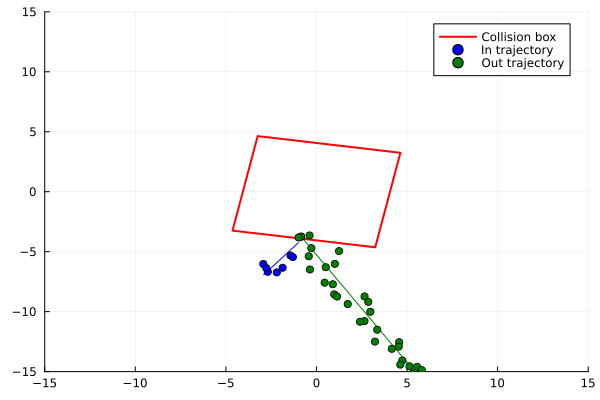

In [1436]:
scale = 4
theta = 80*0.0174533 # degrees to radians
box = makeBox(theta,scale) 
O_in = [-3.0;-7.0]
V_in = normalize([3.0,4.0])
# O_out, V_out, t_out = getOutTrajectory(box, scale, O_in, V_in)

ts = [0:0.5:21;]
jitter_x = 0.5
jitter_y = 0.5
x_in, y_in, x_out, y_out, i_in_count, i_out_count, O_out, V_out, t_out = line_model(O_in, V_in, ts, jitter_x, jitter_y, box)
trace = Gen.simulate(line_model, (O_in, V_in, ts, jitter_x, jitter_y, box));
choices = Gen.get_choices(trace)
render_trace(trace)

### Inference

In [1437]:
# do posterior inference. Conditioned on the before-collision data points, the after-collision data points, guess the
# before-collision and after-collision trajectories
function do_inference(model, xs, ys, amount_of_computation, O_in, V_in, ts, jitter_x, jitter_y, box)
    observations = Gen.choicemap()
    for (i, x) in enumerate(xs)
        observations[(:x, i)] = x
    end
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    # Call importance_resampling to obtain a likely trace consistent with our observations.
    (trace, _) = Gen.importance_resampling(model, (O_in, V_in, ts, jitter_x, jitter_y, box), observations, amount_of_computation);
    return trace
end;

In [1438]:
# calculates the angle bisector of the in-trajectory and out-trajectory to infer the normal of the side of the box
# based off of the inferred normal, calculates the rotation (theta) of the box
function getTheta(trace)
    x_in, y_in, x_out, y_out, i_in_count, i_out_count = get_retval(trace)
    x1 = x_in(ts[1])
    y1 = y_in(ts[1])
    x2 = x_in(ts[i_in_count])
    y2 = y_in(ts[i_in_count])
    x3 = x_out(ts[i_in_count+1])
    y3 = y_out(ts[i_in_count+1])
    x4 = x_out(ts[i_in_count+i_out_count])
    y4 = y_out(ts[i_in_count+i_out_count])
    
    AB = normalize([x1;y1]-[x2;y2]) 
    BC = normalize([x4;y4]-[x3;y3])
    bisector = normalize(AB + BC) # tail to tail

    angle = 0
    if bisector[1] >= 0 && bisector[2] >= 0  #quadrant 1
        angle = acos(dot(bisector,[1.0;0.0]))
    elseif bisector[1] <= 0 && bisector[2] >= 0 # quadrant 2
        angle = acos(dot(bisector,[0.0;1.0]))
    elseif bisector[1] <= 0 && bisector[2] <= 0 #quadrant 3
        angle = acos(dot(bisector, [-1.0;0.0]))
    else
        angle = acos(dot(bisector,[0.0;-1.0])) # quadrant 4
    end
    return angle * 57.2958 # returns in degrees
end

getTheta (generic function with 1 method)

In [1439]:
function inferTheta(box, O_in, V_in)
    scale = 4
    O_out, V_out, t_out = getOutTrajectory(box, scale, O_in, V_in)
    ts = [0:0.5:20;]
    jitter_x = 0.5
    jitter_y = 0.5
    x_in, y_in, x_out, y_out, i_in_count, i_out_count, O_out, V_out, t_out = line_model(O_in, V_in, ts, jitter_x, jitter_y, box)
    trace = Gen.simulate(line_model, (O_in, V_in, ts, jitter_x, jitter_y, box));
    choices = Gen.get_choices(trace)
    render_trace(trace)
    all_traj = [(trace[(:x, i)],trace[(:y, i)]) for i=1:i_in_count+i_out_count]
    infTrace = do_inference(line_model, map(x->x[1],all_traj), map(x->x[2],all_traj), 10, O_in, V_in, ts, jitter_x, jitter_y, box);
    sample_theta = getTheta(infTrace)
    rendered_inf = render_trace(infTrace)
    return sample_theta, rendered_inf
end

inferTheta (generic function with 1 method)

Guessed rotation of box: 78.58131325412363 degrees

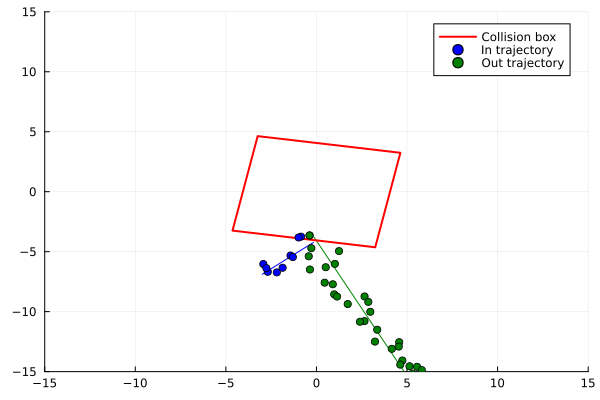

In [1440]:
# continued from example above
all_traj = [(trace[(:x, i)],trace[(:y, i)]) for i=1:i_in_count+i_out_count]
infTrace = do_inference(line_model, map(x->x[1],all_traj), map(x->x[2],all_traj), 10,O_in, V_in, ts, jitter_x, jitter_y, box);
theta = getTheta(infTrace)
print("Guessed rotation of box: ", theta, " degrees")
render_trace(infTrace)

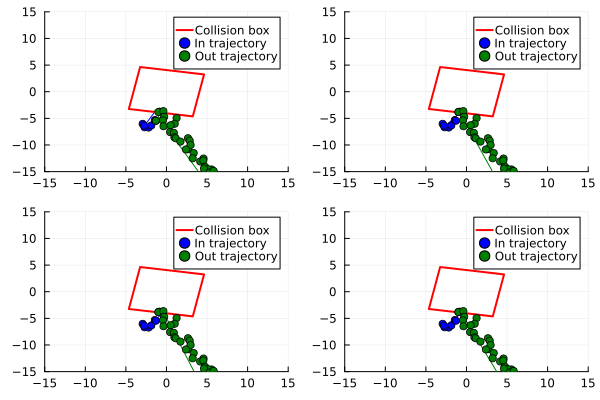

In [1441]:
traces = [do_inference(line_model, map(x->x[1],all_traj), map(x->x[2],all_traj), 10, O_in, V_in, ts, jitter_x, jitter_y, box) for _=1:4];
grid(render_trace, (traces))

### Testing it out

In [1442]:
scale = 4
#The possible boxes are 15, 30, 45, 60, 75 degrees
squares = [makeBox(15*0.0174533,scale), makeBox(30*0.0174533,scale), makeBox(45*0.0174533,scale), makeBox(60*0.0174533,scale),  makeBox(75*0.0174533,scale)];

# Pretend we are throwing the ball at these 2 locations with these 2 velocities
O_in3 = [-3.0;-10.0]
V_in3 = normalize([3.0,4.0])

O_in1 = [3.0;7.0]
V_in1 = normalize([-3.0,-4.0]);

In [1443]:
ix = rand((1,2,3,4,5)) # get random box
box = squares[ix]
res = 0
for i in 1:10
    angle, plot = inferTheta(box, O_in1, V_in1)
    res += angle/20.0
    angle, plot = inferTheta(box, O_in3, V_in3)
    res += angle/20.0
end
print(res)

57.79735162338119

In [1444]:
# ix: 1 = 15 deg, 2 = 30 deg, 3 = 45 deg, 4 = 60 deg, 5 = 75 deg
ix

4

^^ Yay! The box was the 15 degree box and we guessed 13.78 degrees which is close to 15

Any random rotation from 1 - 89 degree:

In [1449]:
theta = rand([1:1:89;])
box = makeBox(theta*0.0174533,4)
O_in3 = [-3.0;-10.0]
V_in3 = normalize([3.0,4.0])
O_in1 = [3.0;7.0]
V_in1 = normalize([-3.0,-4.0]);

res = 0
for i in 1:10
    angle, plot = inferTheta(box, O_in1, V_in1)
    res += angle/20.0
    angle, plot = inferTheta(box, O_in3, V_in3)
    res += angle/20.0
end
print(res)

14.789384521741717

In [1450]:
theta

14